In [2]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
%matplotlib inline

In [3]:


fpath_nytimes = 'facebook_data_nytimes_post_sentiment_4dict.tsv'
post_data_nytimes = pd.read_csv(fpath_nytimes, sep='\t')
post_data_nytimes["News_Agiency"] = 'nytimes'


fpath_WSJ = 'facebook_data_WSJ_post_sentiment_4dict.tsv'
post_data_WSJ = pd.read_csv(fpath_WSJ, sep='\t')
post_data_WSJ["News_Agiency"] = 'WSJ'

In [4]:
post_data = pd.concat([post_data_nytimes
                      ,post_data_WSJ])
post_data.head()

,ID,PostID,PostDate,Text,Likes,Shares,WNPositive,WNNegative,WNNeutral,WNSentiment,...,HVSentiAvg,LMPositive,LMNegative,LMTokenQnt,LMSentiAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound,News_Agiency
0,1,1.015271e+16,2021-06-13 13:55:08.667656,"Renting is, in fact, cheaper than buying these...",135,32,0.000,0.500,5.500,-0.500,...,0.285714,0,0,7,0.000000,0.0,0.000,1.000,0.0000,nytimes
1,2,1.015271e+16,2021-06-13 13:40:09.535354,A provocative new exhibition series makes the ...,42,10,1.000,0.875,18.125,0.125,...,0.041667,0,2,24,-0.083333,0.0,0.024,0.976,-0.0258,nytimes
2,3,1.015271e+16,2021-06-13 13:25:11.470057,The New York Times asked photography students ...,25,5,0.500,0.000,11.500,0.500,...,0.090909,0,0,11,0.000000,0.0,0.000,1.000,0.0000,nytimes
3,4,1.015271e+16,2021-06-13 13:21:12.598040,The world's most famous sports venues are ofte...,31,4,0.625,0.250,16.125,0.375,...,0.416667,0,0,12,0.000000,0.0,0.000,1.000,0.0000,nytimes
4,5,1.015271e+16,2021-06-13 13:21:13.300163,"“We’re back, we’re home,” one passenger yelled...",120,8,0.000,0.000,11.000,0.000,...,0.062500,0,0,16,0.000000,0.0,0.000,1.000,0.0000,nytimes


In [7]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

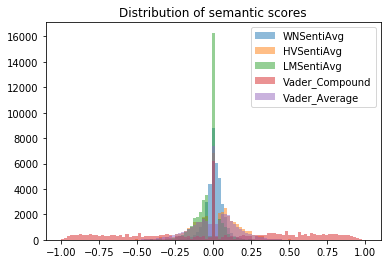

In [8]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['WNSentiAvg'], bins, alpha=0.5, label='WNSentiAvg')
pyplot.hist(post_data['HVSentiAvg'], bins, alpha=0.5, label='HVSentiAvg')
pyplot.hist(post_data['LMSentiAvg'], bins, alpha=0.5, label='LMSentiAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Vader_Positive'] - post_data['Vader_Negative'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

Text(0, 0.5, 'Posts')

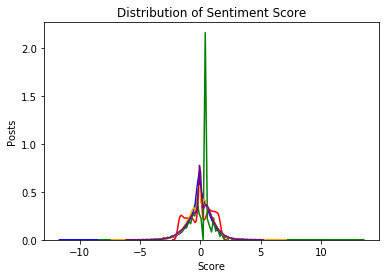

In [9]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['WNSentiAvg'] - post_data['WNSentiAvg'].mean())/post_data['WNSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['LMSentiAvg'] - post_data['LMSentiAvg'].mean())/post_data['LMSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['HVSentiAvg'] - post_data['HVSentiAvg'].mean())/post_data['HVSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'purple',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [10]:
post_data[['WNSentiAvg','HVSentiAvg','LMSentiAvg','Vader_Compound','Vader_Average']].describe()

,WNSentiAvg,HVSentiAvg,LMSentiAvg,Vader_Compound,Vader_Average
count,38221.000000,38221.000000,38221.000000,38221.000000,38221.000000
mean,0.008670,0.017683,-0.033372,0.026794,0.005980
std,0.055710,0.145604,0.077819,0.534357,0.140287
min,-0.625000,-1.000000,-0.666667,-0.990300,-0.808000
25%,-0.018750,-0.071429,-0.071429,-0.401900,-0.074000
50%,0.006579,0.000000,0.000000,0.000000,0.000000
75%,0.038462,0.111111,0.000000,0.476700,0.092000
max,0.479167,1.000000,1.000000,0.985500,0.688000


In [13]:
post_data[['News_Agiency','WNSentiAvg','HVSentiAvg','LMSentiAvg','Vader_Compound','Vader_Average']].groupby('News_Agiency').describe().transpose()

News_Agiency                   WSJ       nytimes
WNSentiAvg     count  20383.000000  17838.000000
               mean       0.007444      0.010070
               std        0.056501      0.054760
               min       -0.625000     -0.312500
               25%       -0.018750     -0.017857
               50%        0.004310      0.007812
               75%        0.035714      0.041667
               max        0.479167      0.333333
HVSentiAvg     count  20383.000000  17838.000000
               mean       0.022795      0.011841
               std        0.130837      0.160632
               min       -0.666667     -1.000000
               25%       -0.058824     -0.083333
               50%        0.000000      0.000000
               75%        0.105263      0.111111
               max        0.700000      1.000000
LMSentiAvg     count  20383.000000  17838.000000
               mean      -0.028422     -0.039029
               std        0.070412      0.085151
               min       -0.500000     -0.666667
               25%       -0.062500     -0.083333
               50%        0.000000      0.000000
               75%        0.000000      0.000000
               max        0.500000      1.000000
Vader_Compound count  20383.000000  17838.000000
               mean       0.047642      0.002970
               std        0.512540      0.557303
               min       -0.987000     -0.990300
               25%       -0.340000     -0.493900
               50%        0.000000      0.000000
               75%        0.476700      0.476700
               max        0.982100      0.985500
Vader_Average  count  20383.000000  17838.000000
               mean       0.011205      0.000010
               std        0.137184      0.143522
               min       -0.744000     -0.808000
               25%       -0.065000     -0.085000
               50%        0.000000      0.000000
               75%        0.095000      0.088000
               max        0.632000      0.688000

In [14]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')

In [15]:
post_data['DateMonth'].head()

0    2021-06
1    2021-06
2    2021-06
3    2021-06
4    2021-06
Name: DateMonth, dtype: object

In [16]:
post_data.columns

Index(['ID', 'PostID', 'PostDate', 'Text', 'Likes', 'Shares', 'WNPositive',
       'WNNegative', 'WNNeutral', 'WNSentiment', 'WNTokenQnt', 'WNSentiAvg',
       'HVPositive', 'HVNegative', 'HVTokenQnt', 'HVSentiAvg', 'LMPositive',
       'LMNegative', 'LMTokenQnt', 'LMSentiAvg', 'Vader_Positive',
       'Vader_Negative', 'Vader_Neutral', 'Vader_Compound', 'News_Agiency',
       'Vader_Average', 'DateMonth', 'DateDay'],
      dtype='object')

In [17]:
Monthly_Data = post_data.groupby('DateMonth').agg({'WNSentiAvg': 'sum'
                                                         ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                       })

In [18]:
DailyData = post_data.groupby('DateDay').agg({'WNSentiAvg': 'sum'
                                                        ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                        })

In [19]:
DailyData['WNSentiment'] =  DailyData['WNSentiAvg']/ DailyData['WNTokenQnt']
DailyData['HVSentiment'] = (DailyData['HVPositive'] - DailyData['HVNegative'])/DailyData['HVTokenQnt']
DailyData['LMSentiment'] = (DailyData['LMPositive'] - DailyData['LMNegative'])/DailyData['LMTokenQnt']

Monthly_Data['WNSentiment'] =  Monthly_Data['WNSentiAvg']/ Monthly_Data['WNTokenQnt']
Monthly_Data['HVSentiment'] = (Monthly_Data['HVPositive'] - Monthly_Data['HVNegative'])/Monthly_Data['HVTokenQnt']
Monthly_Data['LMSentiment'] = (Monthly_Data['LMPositive'] - Monthly_Data['LMNegative'])/Monthly_Data['LMTokenQnt']



In [20]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['WNSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -10.9219
p-value                           0.0000
#Lags Used                       16.0000
Number of Observations Used    2988.0000
Critical Value (1%)              -3.4325
Critical Value (5%)              -2.8625
Critical Value (10%)             -2.5673
dtype: float64


In [21]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['HVSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -8.0445
p-value                           0.0000
#Lags Used                       21.0000
Number of Observations Used    2983.0000
Critical Value (1%)              -3.4325
Critical Value (5%)              -2.8625
Critical Value (10%)             -2.5673
dtype: float64


In [22]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['LMSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                   -8.0445
p-value                           0.0000
#Lags Used                       21.0000
Number of Observations Used    2983.0000
Critical Value (1%)              -3.4325
Critical Value (5%)              -2.8625
Critical Value (10%)             -2.5673
dtype: float64
Results of Dickey-Fuller Test:


In [23]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['Vader_Compound'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                   -6.4239
p-value                           0.0000
#Lags Used                       21.0000
Number of Observations Used    2983.0000
Critical Value (1%)              -3.4325
Critical Value (5%)              -2.8625
Critical Value (10%)             -2.5673
dtype: float64
Results of Dickey-Fuller Test:


In [24]:
DailyData.head()

,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
DateDay,,,,,,,,,,,,,
2009-01-15,0.025000,2,0.34540,0.036000,5,1,42,0,0,42,0.012500,0.095238,0.000000
2009-01-16,0.335227,4,0.24755,0.185750,4,0,46,0,1,46,0.083807,0.086957,-0.021739
2009-01-18,0.000000,1,0.00000,0.000000,1,1,19,0,1,19,0.000000,0.000000,-0.052632
2009-01-20,0.026961,3,0.31480,0.088333,11,2,52,1,2,52,0.008987,0.173077,-0.019231
2009-01-21,0.070455,3,0.30860,0.042667,14,5,89,2,1,89,0.023485,0.101124,0.011236


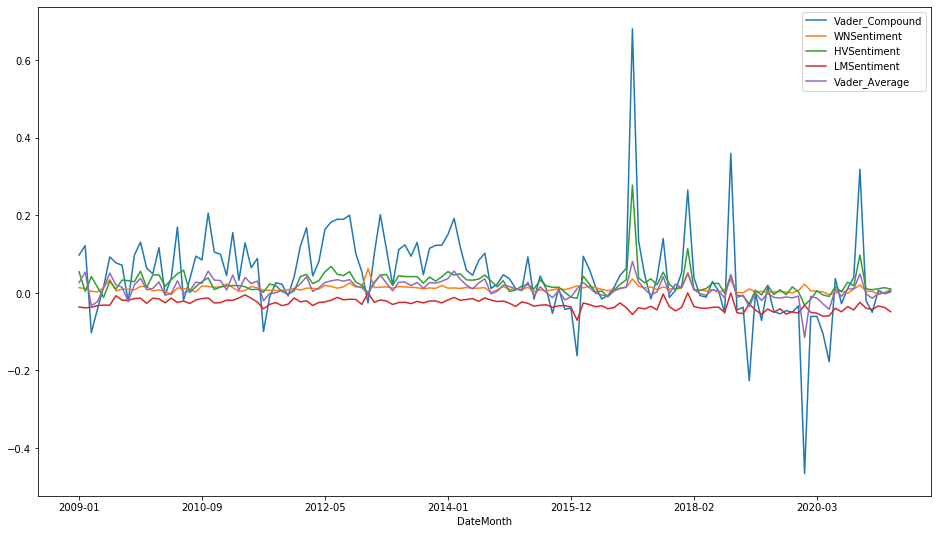

In [25]:
Monthly_Data[['Vader_Compound','WNSentiment','HVSentiment','LMSentiment','Vader_Average']].plot(legend=True, figsize=(16,9))

## Download S&P from Yahoo

In [26]:
SnP_daily = web.get_data_yahoo('^GSPC','01/01/2010','05/01/2021',interval='d')
SnP_monthly = web.get_data_yahoo('^GSPC','01/01/2010','05/01/2021',interval='m')

In [27]:
SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [28]:
SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

In [29]:
SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [30]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [31]:
def grangerTest(exog, endog):
    MAX_LAG = 30
    ARaic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numExog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for exog data is " + str(numExog))

    ARaic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numEndog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for endog data is " + str(numEndog))

    # now that I know the optimal number of parameters, I can call the
    # granger causality function of statsmodels.
    data = pd.concat([endog, exog], axis=1)
    print ("\nGranger causality results of indep onto dep")
    results = grangercausalitytests(data, maxlag=numEndog)

    data = pd.concat([exog, endog], axis=1)
    print ("\nGranger causality results of dep onto indep")
    results = grangercausalitytests(data, maxlag=numExog)
    regr = results[2][1]
    print (regr[0].params)
    print (regr[1].params)
    print (regr[1].pvalues)

In [32]:
Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [33]:
Granger_data_daily.head()

,High,Low,Open,Close,Volume,Adj Close,LogReturn,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
2010-01-04,1133.869995,1116.560059,1116.560059,1132.989990,3991400000,1132.989990,NaN,-0.218750,1,-0.784500,-0.4670,0,2,9,0,1,9,-0.218750,-0.222222,-0.111111
2010-01-05,1136.630005,1129.660034,1132.660034,1136.520020,2491020000,1136.520020,0.003111,-0.033929,4,-0.187475,-0.0500,6,5,60,0,2,60,-0.008482,0.016667,-0.033333
2010-01-06,1139.189941,1133.949951,1135.709961,1137.140015,4972660000,1137.140015,0.000545,0.079782,5,0.006000,0.0246,9,7,74,2,1,74,0.015956,0.027027,0.013514
2010-01-07,1142.459961,1131.319946,1136.270020,1141.689941,5270680000,1141.689941,0.003993,0.076786,2,0.089050,0.0520,3,1,31,1,1,31,0.038393,0.064516,0.000000
2010-01-08,1145.390015,1136.219971,1140.520020,1144.979980,4389590000,1144.979980,0.002878,0.025000,1,0.449700,0.1040,1,2,12,1,1,12,0.025000,-0.083333,0.000000


In [34]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [35]:
Vars = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]
for Var in Vars:
    print("\n" + Var + "\n")
    grangerTest(Granger_data_daily[Var][1:], Granger_data_daily['LogReturn'][1:])


Vader_Compound

Optimal number of lags for exog data is 5

C:\Users\Windows\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)



Optimal number of lags for endog data is 3

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1299  , p=0.7186  , df_denom=1968, df_num=1
ssr based chi2 test:   chi2=0.1301  , p=0.7183  , df=1
likelihood ratio test: chi2=0.1301  , p=0.7183  , df=1
parameter F test:         F=0.1299  , p=0.7186  , df_denom=1968, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0628  , p=0.9391  , df_denom=1965, df_num=2
ssr based chi2 test:   chi2=0.1259  , p=0.9390  , df=2
likelihood ratio test: chi2=0.1259  , p=0.9390  , df=2
parameter F test:         F=0.0628  , p=0.9391  , df_denom=1965, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6093  , p=0.6089  , df_denom=1962, df_num=3
ssr based chi2 test:   chi2=1.8345  , p=0.6075  , df=3
likelihood ratio test: chi2=1.8337  , p=0.6076  , df=3
parameter F test:         F=0.6093  , p=0.6089  , df_denom=1962, df_num=3

Optimal number of lags for exog data is 14
Optimal number of lags for endog data is 3

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0798  , p=0.7775  , df_denom=1968, df_num=1
ssr based chi2 test:   chi2=0.0800  , p=0.7773  , df=1
likelihood ratio test: chi2=0.0800  , p=0.7773  , df=1
parameter F test:         F=0.0798  , p=0.7775  , df_denom=1968, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9192  , p=0.3990  , df_denom=1965, df_num=2
ssr based chi2 test:   chi2=1.8431  , p=0.3979  , df=2
likelihood ratio test: chi2=1.8422  , p=0.3981  , df=2
parameter F test:         F=0.9192  , p=0.3990  , df_denom=1965, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8726  , p=0.4545  , df_denom=1962, df_num=3
ssr based chi2 test:   chi2=2.6273  , p=0.4527  , df=3
likelihood ratio test: chi2=2.6255  , p=0.4530  , df=3
parameter F test:         F=0.8

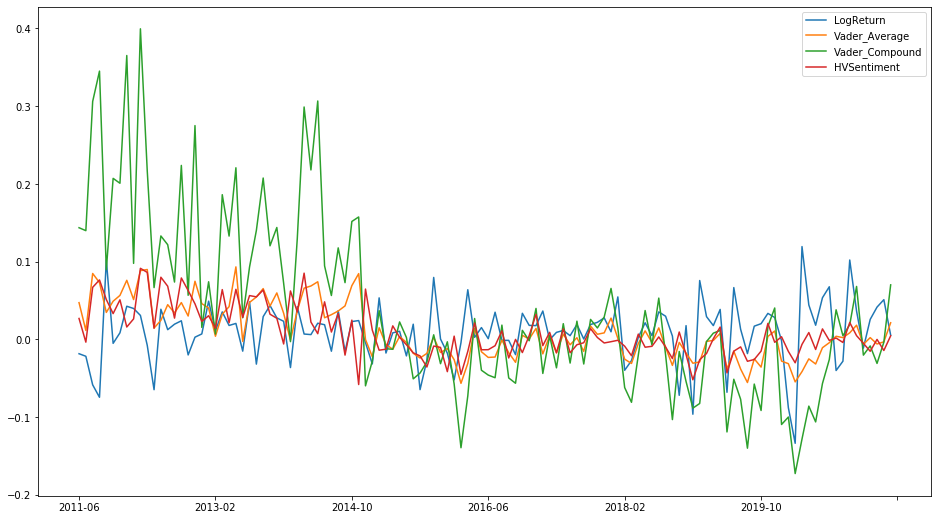

In [28]:
Granger_data_monthly[['LogReturn','Vader_Average','Vader_Compound','HVSentiment']].plot(legend=True, figsize=(16,9))

In [37]:
corr = Granger_data_daily[["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment","LogReturn"]].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Vader_Average,WNSentiment,HVSentiment,LMSentiment,LogReturn
Vader_Compound,1.000000,0.918227,0.366603,0.546172,0.518468,0.032418
Vader_Average,0.918227,1.000000,0.391086,0.535867,0.495261,0.037247
WNSentiment,0.366603,0.391086,1.000000,0.306799,0.250131,0.028643
HVSentiment,0.546172,0.535867,0.306799,1.000000,0.494010,0.027028
LMSentiment,0.518468,0.495261,0.250131,0.494010,1.000000,0.035419
LogReturn,0.032418,0.037247,0.028643,0.027028,0.035419,1.000000


In [38]:
pvals = [] 
for col in ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"])
corr_signif

,p-value
Vader_Compound,0.150130
Vader_Average,0.098217
WNSentiment,0.203575
HVSentiment,0.230256
LMSentiment,0.115868


In [38]:
pvals_mnt = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals_mnt.append(scipy.stats.linregress(Granger_data_monthly['LogReturn'][1:], Granger_data_monthly[col][1:].dropna())[3])
corr_signif_mnt = pd.DataFrame(pvals_mnt,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif_mnt

,p-value
Vader_Compound,0.084306
Flair_Score,0.977764
SentimentScoreAdj,0.311650
Vader_Average,0.047369
